# Dimensionality Reduction: Principal Component Analysis in-depth

In [2]:
import warnings
warnings.filterwarnings('ignore')

from __future__ import print_function, division

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# use seaborn plotting style defaults
import seaborn as sns; sns.set()

## Introducing Principal Component Analysis

Principal Component Analysis is a very powerful unsupervised method for *dimensionality reduction* in data.  It's easiest to visualize by looking at a two-dimensional dataset:

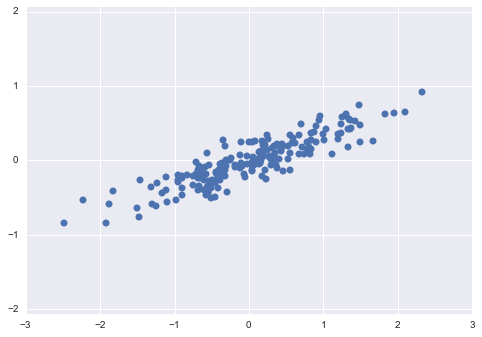

In [3]:
np.random.seed(1)
X = np.dot(np.random.random(size=(2, 2)), np.random.normal(size=(2, 200))).T
plt.plot(X[:, 0], X[:, 1], 'o')
plt.axis('equal');

We can see that there is a definite trend in the data. What PCA seeks to do is to find the **Principal Axes** in the data, and explain how important those axes are in describing the data distribution:

In [6]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)
print(pca.explained_variance_ratio_)
print(pca.components_)

[ 0.97634101  0.02365899]
[[ 0.94446029  0.32862557]
 [ 0.32862557 -0.94446029]]


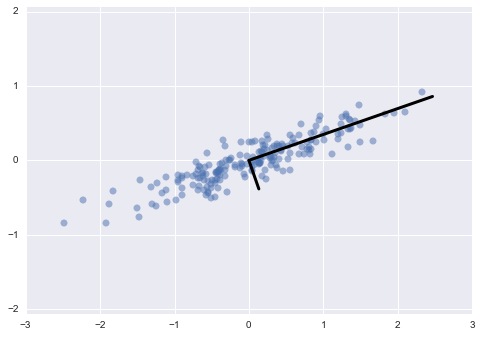

In [7]:
plt.plot(X[:, 0], X[:, 1], 'o', alpha=0.5)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    plt.plot([0, v[0]], [0, v[1]], '-k', lw=3)
plt.axis('equal');

Notice that one vector is longer than the other. In a sense, this tells us that that direction in the data is somehow more "important" than the other direction.
The explained variance quantifies this measure of "importance" in direction.

Another way to think of it is that the second principal component could be **completely ignored** without much loss of information! Let's see what our data look like if we only keep 95% of the variance:

In [8]:
clf = PCA(0.95) # keep 95% of variance
X_trans = clf.fit_transform(X)
print(X.shape)
print(X_trans.shape)

(200L, 2L)
(200L, 1L)


By specifying that we want to throw away 5% of the variance, the data is now compressed by a factor of 50%! Let's see what the data look like after this compression:

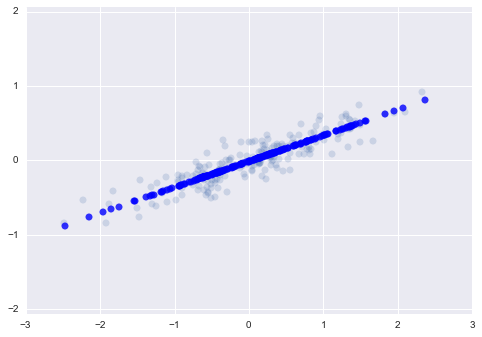

In [9]:
X_new = clf.inverse_transform(X_trans)
plt.plot(X[:, 0], X[:, 1], 'o', alpha=0.2)
plt.plot(X_new[:, 0], X_new[:, 1], 'ob', alpha=0.8)
plt.axis('equal');

### Application of PCA to Digits

The dimensionality reduction might seem a bit abstract in two dimensions, but the projection and dimensionality reduction can be extremely useful when visualizing high-dimensional data.  Let's take a quick look at the application of PCA to the digits data we looked at before:

In [10]:
from sklearn.datasets import load_digits
digits = load_digits()
X = digits.data
y = digits.target

In [11]:
pca = PCA(2)  # project from 64 to 2 dimensions
Xproj = pca.fit_transform(X)
print(X.shape)
print(Xproj.shape)

(1797L, 64L)
(1797L, 2L)


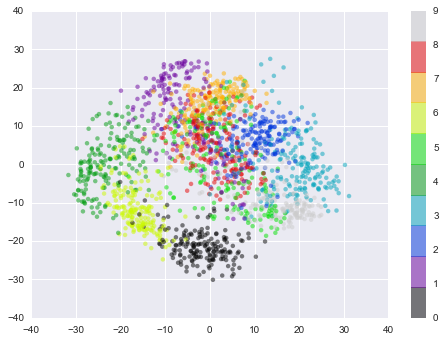

In [12]:
plt.scatter(Xproj[:, 0], Xproj[:, 1], c=y, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar();

### What do the Components Mean?

PCA is a very useful dimensionality reduction algorithm, because it has a very intuitive interpretation via *eigenvectors*.
The input data is represented as a vector: in the case of the digits, our data is

$$
x = [x_1, x_2, x_3 \cdots]
$$

but what this really means is

$$
image(x) = x_1 \cdot{\rm (pixel~1)} + x_2 \cdot{\rm (pixel~2)} + x_3 \cdot{\rm (pixel~3)} \cdots
$$

If we reduce the dimensionality in the pixel space to (say) 6, we recover only a partial image:

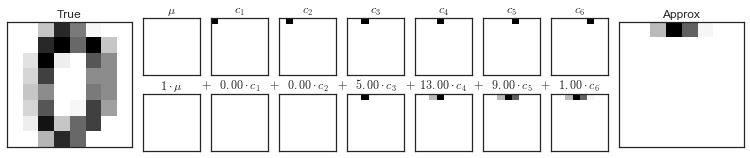

In [13]:
from fig_code.figures import plot_image_components

sns.set_style('white')
plot_image_components(digits.data[0])

But the pixel-wise representation is not the only choice. We can also use other *basis functions*, and write something like

$$
image(x) = {\rm mean} + x_1 \cdot{\rm (basis~1)} + x_2 \cdot{\rm (basis~2)} + x_3 \cdot{\rm (basis~3)} \cdots
$$

What PCA does is to choose optimal **basis functions** so that only a few are needed to get a reasonable approximation.
The low-dimensional representation of our data is the coefficients of this series, and the approximate reconstruction is the result of the sum:

### Choosing the Number of Components

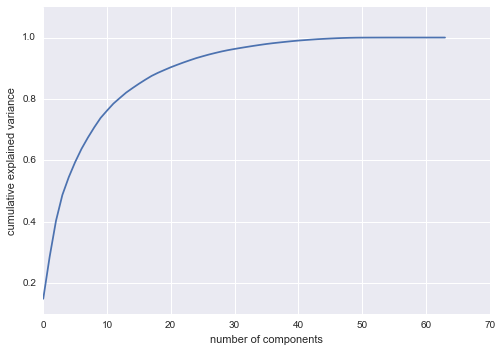

In [15]:
sns.set()
pca = PCA().fit(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

Here we see that our two-dimensional projection loses a lot of information (as measured by the explained variance) and that we'd need about 20 components to retain 90% of the variance.  Looking at this plot for a high-dimensional dataset can help you understand the level of redundancy present in multiple observations.

### PCA as data compression

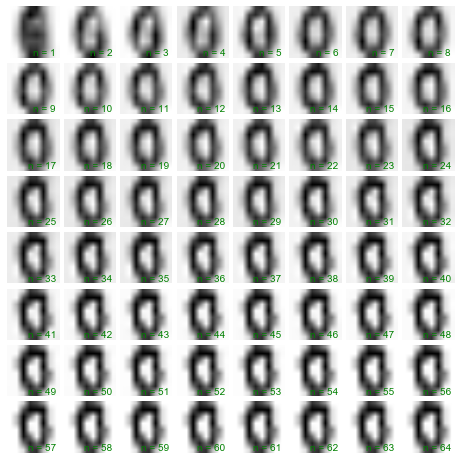

In [16]:
fig, axes = plt.subplots(8, 8, figsize=(8, 8))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

for i, ax in enumerate(axes.flat):
    pca = PCA(i + 1).fit(X)
    im = pca.inverse_transform(pca.transform(X[20:21]))

    ax.imshow(im.reshape((8, 8)), cmap='binary')
    ax.text(0.95, 0.05, 'n = {0}'.format(i + 1), ha='right',
            transform=ax.transAxes, color='green')
    ax.set_xticks([])
    ax.set_yticks([])

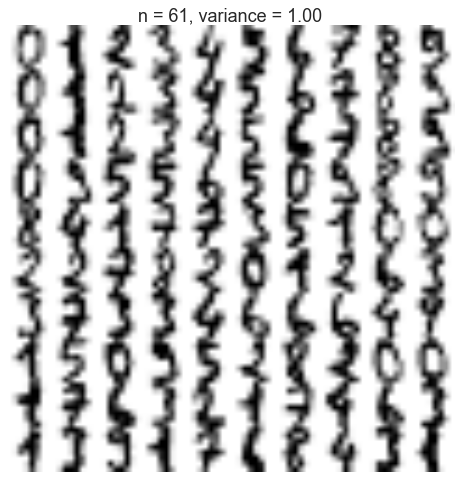

In [17]:
from IPython.html.widgets import interact

def plot_digits(n_components):
    fig = plt.figure(figsize=(8, 8))
    plt.subplot(1, 1, 1, frameon=False, xticks=[], yticks=[])
    nside = 10
    
    pca = PCA(n_components).fit(X)
    Xproj = pca.inverse_transform(pca.transform(X[:nside ** 2]))
    Xproj = np.reshape(Xproj, (nside, nside, 8, 8))
    total_var = pca.explained_variance_ratio_.sum()
    
    im = np.vstack([np.hstack([Xproj[i, j] for j in range(nside)])
                    for i in range(nside)])
    plt.imshow(im)
    plt.grid(False)
    plt.title("n = {0}, variance = {1:.2f}".format(n_components, total_var),
                 size=18)
    plt.clim(0, 16)
    
interact(plot_digits, n_components=[1, 64], nside=[1, 8]);